In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ProjectPaths import ProjectPaths

ProjectPaths.instance()

In [3]:
mask_images = np.load(ProjectPaths.instance().file_in_image_dir("ds_image_masks.npy"))

In [4]:
images = np.load(ProjectPaths.instance().file_in_image_dir("ds_images.npy"))

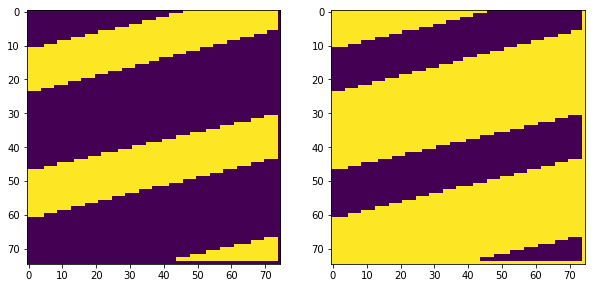

In [5]:
%matplotlib inline

def inverse_mask(mask):
    return ((mask == 0) * 255).astype(np.uint8)

_, ax = plt.subplots(1,2, figsize = (10,10))

mask = mask_images[0]
inv_mask = inverse_mask(mask)

ax[0].imshow(mask)
ax[1].imshow(inv_mask)

In [6]:
mask.dtype, inv_mask.dtype

(dtype('uint8'), dtype('uint8'))

In [7]:
inverse_masks = [inverse_mask(mask) for mask in mask_images]

In [8]:
def normalized_hist(hist_image, channel, mask=None):
    hist = cv.calcHist([hist_image], [channel], mask, [256], [0, 255])  
    number_of_pixels = hist_image.size if mask is None else mask[mask > 0].size
    return hist / number_of_pixels

def all_bands_hist(hist_image, mask=None):
    all_bands_hist = []
    for i in range(3):
        all_bands_hist.extend(normalized_hist(hist_image, i, mask))
    return np.array(all_bands_hist)

def plot_hist(hist_image, mask=None):
    normalized_counts = []
    for i, col in enumerate(["b", "g", "r"]):
        normalized_counts.append(normalized_hist(hist_image, i, mask))
        plt.plot(normalized_counts,color = col)
        plt.xlim([0,255])
    return np.array(normalized_counts)

In [42]:
def image_with_mask(image, mask):    
    mask = np.stack((mask, mask, mask), axis = 2)
    return mask * image

In [43]:
image_with_mask(images[0], mask_images[0]).shape

(75, 75, 3)

In [44]:
positive_images = np.array([image_with_mask(hist_image, mask) for hist_image, mask in zip(images, mask_images)])
negative_images = np.array([image_with_mask(hist_image, mask) for hist_image, mask in zip(images, inverse_masks)])

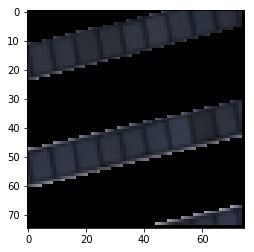

In [45]:
plt.imshow(positive_images[0])

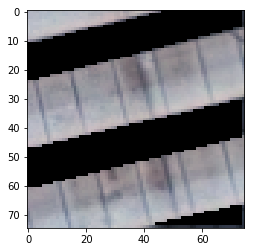

In [46]:
plt.imshow(negative_images[0])

In [9]:
positives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(images, mask_images)]).reshape(120, 768)
negatives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(images, inverse_masks)]).reshape(120, 768)

In [10]:
positives.shape, negatives.shape

((120, 768), (120, 768))

In [11]:
positive_labels = np.ones(120)
negative_labels = np.zeros(120)

In [12]:
all_histograms = np.concatenate((positives, negatives))
all_labels = np.concatenate((positive_labels, negative_labels))
all_histograms.shape, all_labels.shape

((240, 768), (240,))

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_histograms, all_labels, test_size = 0.20)

In [14]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/home/tim/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def predict(clf, X_test, y_test):
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))
    print("accuracy={}".format(accuracy_score(y_test, predictions)))
    print(confusion_matrix(y_test, predictions))

In [16]:
predict(clf, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        24
         1.0       0.96      0.96      0.96        24

   micro avg       0.96      0.96      0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48

accuracy=0.9583333333333334
[[23  1]
 [ 1 23]]


In [17]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01251209, 0.        , 0.        , 0.00205421, 0.00958445,
       0.        , 0.        , 0.        , 0.        , 0.     

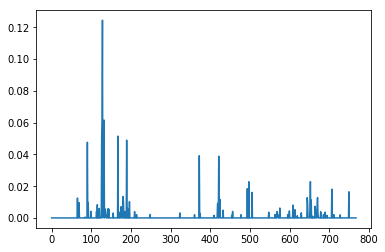

In [18]:
plt.plot(clf.feature_importances_)

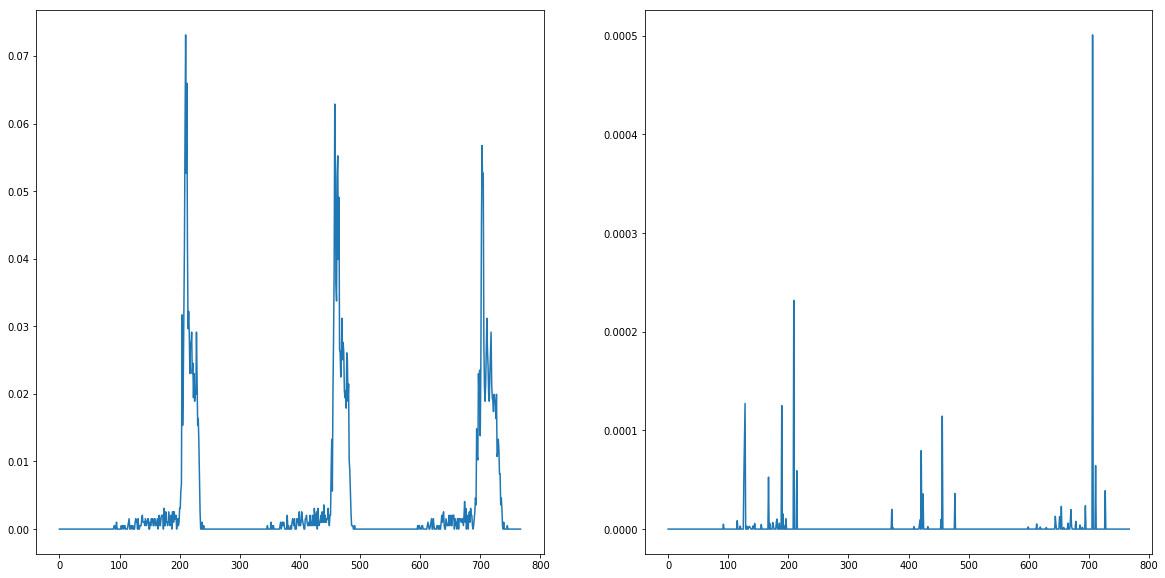

In [19]:
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(all_histograms[0])
ax[1].plot(all_histograms[0] * clf.feature_importances_)

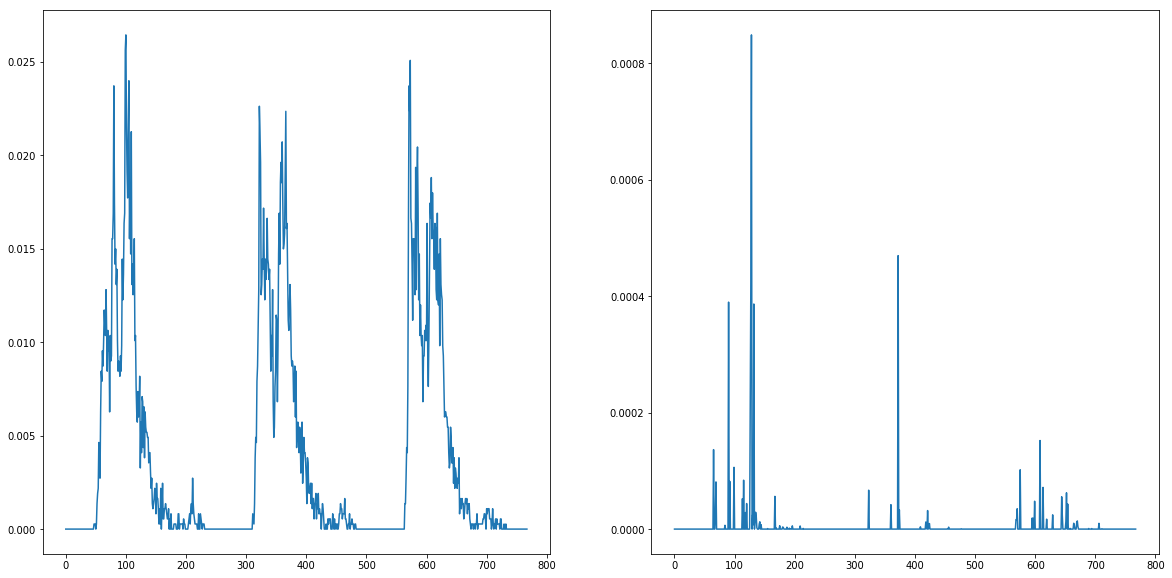

In [20]:
_, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(all_histograms[120])
ax[1].plot(all_histograms[120] * clf.feature_importances_)

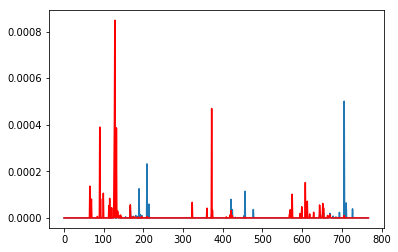

In [21]:
plt.plot(all_histograms[0] * clf.feature_importances_)
plt.plot(all_histograms[120] * clf.feature_importances_, color='r')

# Look at the combined histograms

Sum the separate normalized histogram vectors for each of the separate images to create a combined histogram for all the pictures. By comparing the histograms of the foreground (containing solar panels) with the histograms of the background (without solar panels) we can get an idea of which colors are more important in the foreground pictures, and which ones are more important in background pictures. If we furthermore use feature importances to weigh the histograms, we get an idea which features (=colors) are used to discriminate between classifier classes.

In [22]:
positives_summed_hist = positives.sum(axis=0)
negatives_summed_hist = negatives.sum(axis=0)

In [23]:
positives_summed_hist.min(), positives_summed_hist.max(), negatives_summed_hist.min(), negatives_summed_hist.max()

(0.0, 2.4751441, 0.0, 1.1511271)

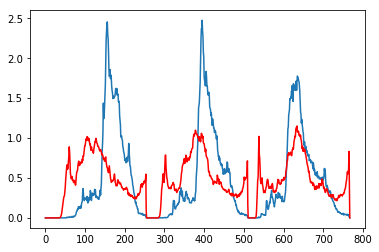

In [24]:
plt.plot(positives_summed_hist)
plt.plot(negatives_summed_hist, color='r')

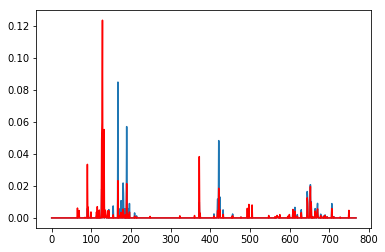

In [25]:
plt.plot(positives_summed_hist * clf.feature_importances_)
plt.plot(negatives_summed_hist * clf.feature_importances_, color='r')

(0, 0.08)

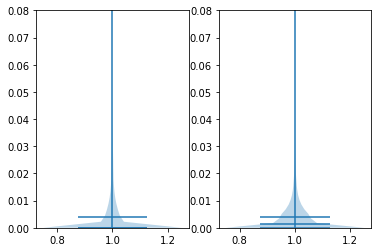

In [26]:
_, ax = plt.subplots(1,2)

ax[0].violinplot(positives.flatten(), showmedians=True, showmeans=True)
ax[0].set_ylim([0, 0.08])
ax[1].violinplot(negatives.flatten(), showmedians=True, showmeans=True)
ax[1].set_ylim([0, 0.08])

# Which features are important?

Explore which features are important to detect solar panels:
* color (normalized rgb images?)
* intensity (gray scale picture)
* texture (local binary patterns)

For each of these values create a normalized histogram of the values for the whole pictures and add them to a feature vector to be used in a classifier. By using a classifier with feature importances, like a RandomForestClassifier, we can get an idea of the relative importances of each feature type.

## RGB Normalized Pictures

To calculate the RGB normalized picture all pixels in each image channel are divided by the total intensity of the pixel. This results in:

\begin{equation}
r' = \frac{r}{r+g+b}
\end{equation}
\begin{equation}
b' = \frac{b}{r+g+b}
\end{equation}
\begin{equation}
g' = \frac{g}{r+g+b}
\end{equation}

Note that only two channels are necessary to reconstruct the picture, when having r' and b', g' is derived as follows:

\begin{equation}
g' = 1 - r' - g'
\end{equation}

In [27]:
def rgb_norm(image):
    sums = image.sum(axis=2).reshape(image.shape[0], image.shape[1], 1).repeat(axis=2, repeats=3)
    return image / sums

In [78]:
rgb_normalized_images = np.array([rgb_norm(image) * 255 for image in images]).astype(np.uint8)
rgb_normalized_images.shape, rgb_normalized_images.dtype

((120, 75, 75, 3), dtype('uint8'))

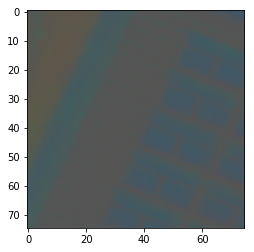

In [79]:
plt.imshow(rgb_normalized_images[3][:,:,::-1])

In [80]:
rgb_positives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(rgb_normalized_images, mask_images)]).reshape(120, 768)
rgb_negatives = np.array([all_bands_hist(hist_image, mask) for hist_image, mask in zip(rgb_normalized_images, inverse_masks)]).reshape(120, 768)
rgb_normalized_positives.shape, rgb_normalized_negatives.shape

((120, 75, 75, 3), (120, 75, 75, 3))

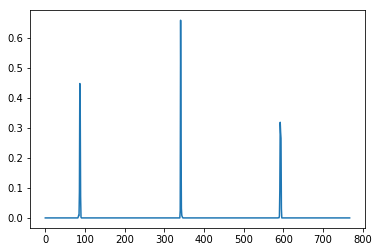

In [81]:
plt.plot(rgb_positives[0])

In [82]:
rgb_positives_summed_hist = rgb_positives.sum(axis=0)
rgb_negatives_summed_hist = rgb_negatives.sum(axis=0)

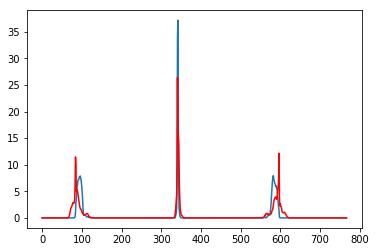

In [83]:
plt.plot(rgb_positives_summed_hist)
plt.plot(rgb_negatives_summed_hist, color="r")

## Intensity

Intensity is calculated by converting the picture to a gray-scale picture using OpenCV. By taking the histogram of this gray-scale picture we are able to extract the intensity as a feature vector.

In [65]:
gray_scale_images = np.array([cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images])

In [72]:
gray_scale_positives = np.array([cv.calcHist([hist_image], [0], mask, [256], [0, 255]) / mask.size for hist_image, mask in zip(gray_scale_images, mask_images)]).reshape(120, 256)
gray_scale_negatives = np.array([cv.calcHist([hist_image], [0], mask, [256], [0, 255]) / mask.size for hist_image, mask in zip(gray_scale_images, inverse_masks)]).reshape(120, 256)
gray_scale_positives.shape, gray_scale_negatives.shape

((120, 256), (120, 256))

In [73]:
gray_scale_positives_summed_hist = gray_scale_positives.sum(axis=0)
gray_scale_negatives_summed_hist = gray_scale_negatives.sum(axis=0)

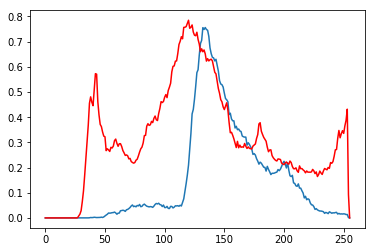

In [74]:
plt.plot(gray_scale_positives_summed_hist)
plt.plot(gray_scale_negatives_summed_hist, color="r")

## Texture differences

To get a feel for texture differences we will use the local binary patterns feature extractor, described here:

https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

In short, this feature extractor looks at textures by comparing a middle pixel with its surrounding pixels and creating a binary mask out of it. If the middle pixel has an intensity greater than that of the surrounding pixel, the surrounding pixel position in the binary mask gets a value 0, otherwise 1. By creating a binary mask this way a value for the middle pixel is obtained. If we repeat this we get a mask image with the same size as the original image. By creating a histogram for this mask image, we can describe the texture information as a feature vector.

## Creating the classifier

By adding all the feature vectors derived above together we can create a feature vector describing color, intensity and texture. If we train a classifier to distinguish between a foreground (solar panel) region and a background region, we can furthermore derive which features are taken into account; that is, if the classifier has a way to derive feature importances. For this purpose, therefore we use a RandomForest classifier which can give us feature importances. In this way, we can get a coarse idea what distinguishes a solar panel from its background.